In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from math import sin
from math import cos

In [2]:
#setup geometry

#assume the earth is a sphere, not an oblate spheroid

num_lat_zones = 18
zonal_width = 90/num_lat_zones
lats = np.linspace(-85,85,18)
lats_rad = lats*(pi/180)
delta_rad = (pi/2)/num_lat_zones/2
lats_frac=np.zeros(18)

for i in range(18):
    lats_frac[i] = sin(lats_rad[i]+delta_rad) - sin(lats_rad[i]-delta_rad)

print(lats_frac)

#geometry successfully setup

[0.00760336 0.02257906 0.0368687  0.05003811 0.06168713 0.07146182
 0.07906518 0.08426619 0.0869068  0.0869068  0.08426619 0.07906518
 0.07146182 0.06168713 0.05003811 0.0368687  0.02257906 0.00760336]


In [3]:
#setup insolation
#constants needed for insolation setup

solar_constant=1370
max_tilt=23.5
days_in_year=365
hours_in_day=24
zonal_degrees=360
total_solar=0.0

In [4]:
#calculate effective solar constant (considering sun angle and day/night cycle)

for hour in range(hours_in_day):
    noon_angle=zonal_degrees*(hour/hours_in_day)
    for longitude in range(zonal_degrees):
        sun_angle=longitude-noon_angle
        total_solar=total_solar+solar_constant*max(0,cos((pi/180)*sun_angle))

solar_constant=total_solar/(hours_in_day*zonal_degrees)
print(solar_constant)
#solar constant reasonable

436.0734741032062


In [5]:
#compute average insolation for each latitude band

insolation=np.zeros(num_lat_zones)

for day in range(days_in_year):
    tilt=max_tilt*cos(2.0*pi*day/(days_in_year+1))
    for j in range(num_lat_zones):
        zenith=min(lats[j]+tilt,90.0)
        insolation[j]=insolation[j]+cos(zenith*pi/180)

insol=solar_constant*insolation/days_in_year
insolation=insolation

avg_insolation=(sum(lats_frac,insolation))
print(avg_insolation)

#insolation values for each latitude band are again reasonable

[ 31.09533615  91.16405345 148.49321056 201.34089005 248.10134192
 287.3537735  317.90551952 338.82828064 349.48632935 349.55582623
 339.03465966 318.24250995 287.81113606 248.66517987 201.99407147
 149.21588887 101.75002582  64.08835228]


In [6]:
#set up parameters for solve_temp


albedo_ice=0.60
albedo_land=0.30
temp_critical=-10

In [7]:
def solve_temp(solar_mult):
    insol=343
    insolation=np.array([343*0.500,343*0.531,343*0.624,343*0.770,343*0.892,343*1.021,343*1.120,343*1.189,343*1.219,343*1.219,
                        343*1.189,343*1.120,343*1.021,343*0.892,343*0.770,343*0.624,343*0.531,343*0.500])
    step_num = 1                 
    max_temp_diff = 1.0E6       
    tol_temp_diff = 0.05         
    max_steps = 100              
    F=3.80
    A=204
    B=2.17
    Ce=2.08e8
    temp=np.array([-16.9,-12.3,-5.1,2.2,8.8,16.2,22.9,26.1,26.4,26.1,24.6,21.4,16.5,9.9,2.9,-6.9,-29.5,-42.3])
    albedo=np.array([0.589,0.544,0.452,0.407,0.357,0.309,0.272,0.248,0.254,0.241,0.236,0.251,0.296,0.358,0.426,0.513,0.602,0.617])
    while step_num < max_steps:
        temp_old=temp
        step_num=step_num+1
    temp_avg=sum(lats_frac,temp)
    temp=(insolation*(1-albedo)+F*temp_avg-A)/(B+F)
    max_temp_diff=max(abs(temp_old-temp))
    return temp

temptest=solve_temp(1)
print(temptest)

[-32.48406697 -27.45121136 -17.13347467  -5.89935507   5.02065799
  17.31220992  27.88812399  34.45050657  35.51740405  36.23692181
  34.31548546  28.2846667   18.26575079   5.66957658  -6.29434502
 -20.46612995 -40.16875139 -49.45592626]


In [8]:
#now, set up simple differential equation
tempavg=15
albedo=np.array([0.589,0.544,0.452,0.407,0.357,0.309,0.272,0.248,0.254,0.241,0.236,0.251,0.296,0.358,0.426,0.513,0.602,0.617])
insol=np.array([343*0.500,343*0.531,343*0.624,343*0.770,343*0.892,343*1.021,343*1.120,343*1.189,343*1.219,343*1.219,
                    343*1.189,343*1.120,343*1.021,343*0.892,343*0.770,343*0.624,343*0.531,343*0.500])
insolation=insol*(31536000**3)
temp=np.array([-16.9,-12.3,-5.1,2.2,8.8,16.2,22.9,26.1,26.4,26.1,24.6,21.4,16.5,9.9,2.9,-6.9,-29.5,-42.3])
F=3.80*(31536000**2)
A=204*(31536000**3)
B=2.17*(31536000**3)
Ce=2.08e8*(31536000**2)
time=np.linspace(0,100,18)
time=np.zeros(80)
temp=np.array([-16.9,-12.3,-5.1,2.2,8.8,16.2,22.9,26.1,26.4,26.1,24.6,21.4,16.5,9.9,2.9,-6.9,-29.5,-42.3])
temptime=np.zeros(100)
tchangeavg=np.zeros(18)
def solve_temp_ode(x,y):
    i=0
    tc=np.zeros(18)
    while i<18:
        tc = ((insolation*(1 - albedo)) - (A + B*temp[i]+F*(temp[i]-tempavg)))/(Ce)
        tchange=(sum(tc)/len(tc))
        i=i+1
    return tchange

tempodetest=solve_temp_ode(time,tempavg)
print(tempodetest)

12.620405470903854


In [ ]:
def rk4ODEinter41(coeff, y, theTime):
    k1 = coeff.dt * derivsinter41(coeff,y,theTime)
    k2 = coeff.dt * derivsinter41(coeff,y + (0.5 * k1),theTime+0.5*coeff.dt)
    k3 = coeff.dt * derivsinter41(coeff,y + (0.5 * k2),theTime+0.5*coeff.dt)
    k4 = coeff.dt * derivsinter41(coeff,y +  k3,theTime+coeff.dt)
    y = y + (1.0/6.0) * (k1 + (2.0 * k2) + (2.0 * k3) + k4)
    return y

In [9]:
# Runge-Kutta 4th order
def rk4(f, x0, y0, x1, n):
    h = (x1 - x0) / n
    x = np.arange(x0, x1, h)
    y = np.zeros((n + 1))
    y[0] = y0
    for i in range(n):
        k1 = h * f(x[i],y[i])
        k2 = h * f(x[i] + h / 2, y[i] + k1 / 2)
        k3 = h * f(x[i] + h / 2, y[i] + k2 / 2)
        k4 = h * f(x[i] + h, y[i] + k3)
        y[i+1] = y[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return x, y

In [10]:
time=np.linspace(2020,2100,80)
temp_rk4=rk4((solve_temp_ode),2020,15,2100,80)
print(temp_rk4)
time1=temp_rk4[0]
temp1=temp_rk4[1]
temp2=temp1[0:80]
for i in range(len(temp2)-1):
    temp3=temp2[i+1]-temp2[i]
print(temp1)

(array([2020., 2021., 2022., 2023., 2024., 2025., 2026., 2027., 2028.,
       2029., 2030., 2031., 2032., 2033., 2034., 2035., 2036., 2037.,
       2038., 2039., 2040., 2041., 2042., 2043., 2044., 2045., 2046.,
       2047., 2048., 2049., 2050., 2051., 2052., 2053., 2054., 2055.,
       2056., 2057., 2058., 2059., 2060., 2061., 2062., 2063., 2064.,
       2065., 2066., 2067., 2068., 2069., 2070., 2071., 2072., 2073.,
       2074., 2075., 2076., 2077., 2078., 2079., 2080., 2081., 2082.,
       2083., 2084., 2085., 2086., 2087., 2088., 2089., 2090., 2091.,
       2092., 2093., 2094., 2095., 2096., 2097., 2098., 2099.]), array([  15.        ,   27.62040547,   40.24081094,   52.86121641,
         65.48162188,   78.10202735,   90.72243283,  103.3428383 ,
        115.96324377,  128.58364924,  141.20405471,  153.82446018,
        166.44486565,  179.06527112,  191.68567659,  204.30608206,
        216.92648753,  229.54689301,  242.16729848,  254.78770395,
        267.40810942,  280.02851489,  2

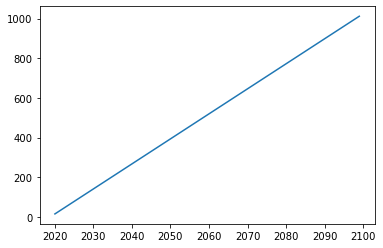

In [11]:
plt.plot(time1,temp2)

In [12]:
temp=np.zeros(num_lat_zones)
temp_avg=np.zeros(num_lat_zones)
for j in range(num_lat_zones):
    temp[j]=-60.0

solar_mult=np.zeros(140)
#for k in range(140):
#    solar_mult[k]=k/100
#    temp_avg=solve_temp(solar_mult);
#    k=k+1
    
#plt.plot(solve_temp(2))
#plt.plot(solar_mult,temp_avg)
#plt.title('Average Temperature versus Solar Multiplier')
#xlabel('Solar Multiplier')
#ylabel('Average Temperature')


In [13]:
#for k in range(60:140):
#    solar_mult[k]=k/100;
#    temp_avg[k]=solve_temp(solar_mult[k])
    
#plt.plot(solar_mult,temp_avg)
#plt.title('Average Temperature versus Solar Multiplier')
#xlabel('Solar Multiplier')
#ylabel('Average Temperature')